## Predicting Heart Disease
The World Health Organization (WHO) estimates that 17.9 million people die every year because of cardiovascular diseases (CVDs).

There are multiple risk factors that could contribute to CVD in an individual such as unhealthy diet, lack of physical activity or mental illnesses. Being able to identify these risk factors in individuals early on could help prevent a lot of premature deaths.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
df = pd.read_csv("heart_disease_prediction.csv")

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


The dataset has the following features:

1. Age: age of the patient [years]
2. Sex: sex of the patient [M: Male, F: Female]
3. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. RestingBP: resting blood pressure [mm Hg]
5. Cholesterol: serum cholesterol [mm/dl]
6. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
9. ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
10. Oldpeak: oldpeak = ST [Numeric value measured in depression]
11. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. HeartDisease: output class [1: heart disease, 0: Normal]


Before we jump into building a model, let's conduct exploratory data analysis on the dataset.

In [4]:
df.shape

(918, 12)

In [5]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [6]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


- The average age of patients is ~53 years. 
- The median for Cholesterol is higher than its mean by roughly 25 mm/dl, indicating that it could be a left-skewed distribution with a possibility of outliers skewing the distribution. 
- RestingBP and Cholesterol have a minimum value of zero.(Unlikely)
- There don't seem to be any missing values in these columns.

In [7]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [8]:
cat_colums = [col for col in df.columns if df[col].dtypes == "object"]

In [9]:
df.describe(include=['object'])

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


In [10]:
df.HeartDisease.value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

In [11]:
df.FastingBS.value_counts()

FastingBS
0    704
1    214
Name: count, dtype: int64

In [12]:
cat_columns = cat_colums + ["HeartDisease", "FastingBS"]
cat_columns

['Sex',
 'ChestPainType',
 'RestingECG',
 'ExerciseAngina',
 'ST_Slope',
 'HeartDisease',
 'FastingBS']

## EDA Visualization

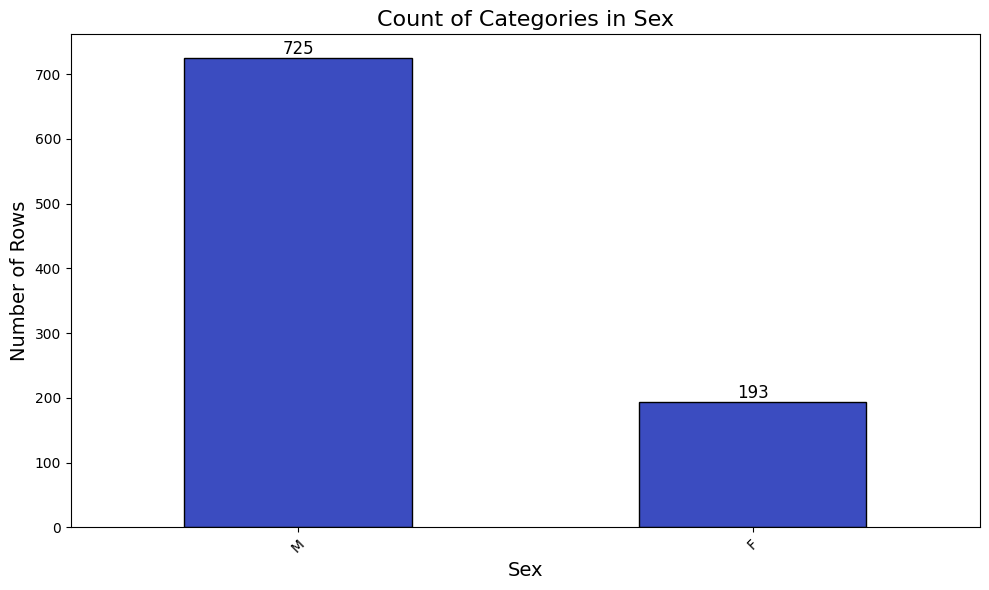

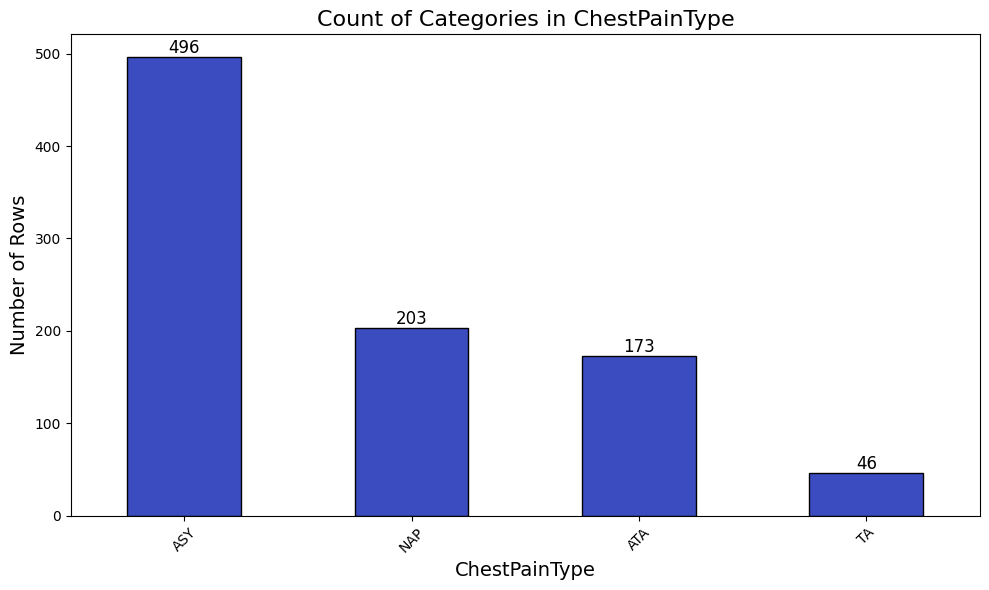

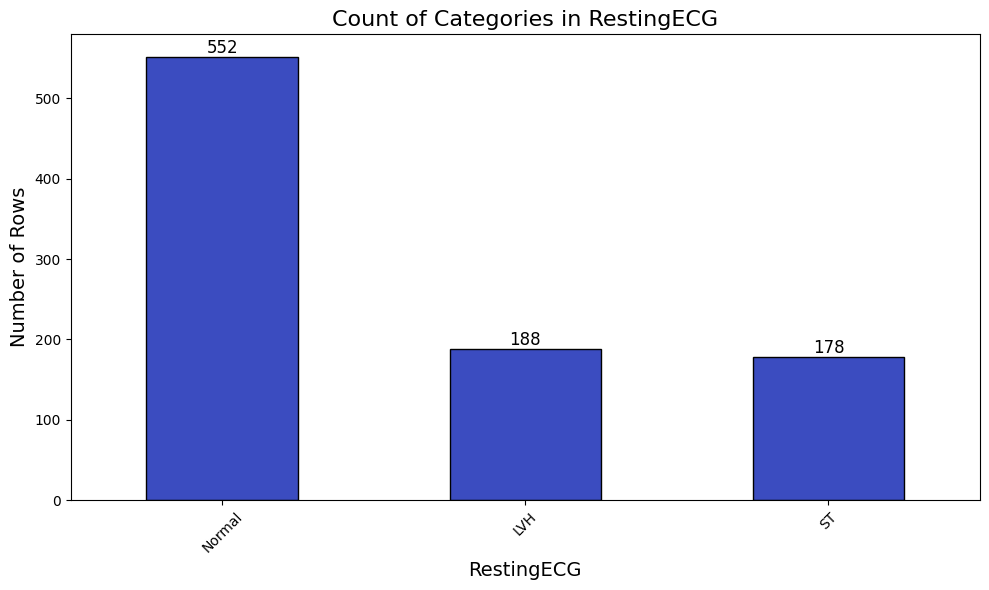

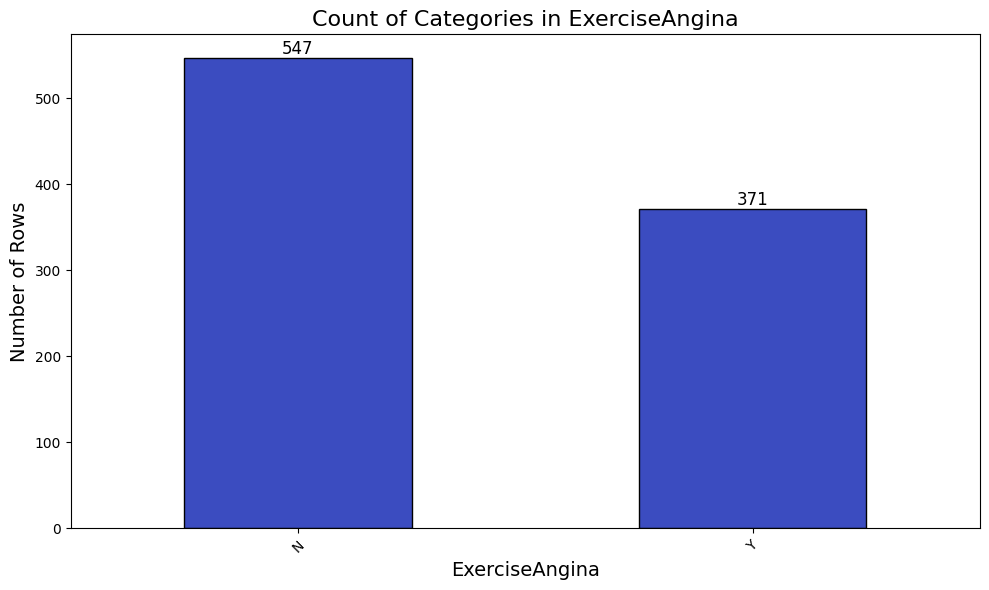

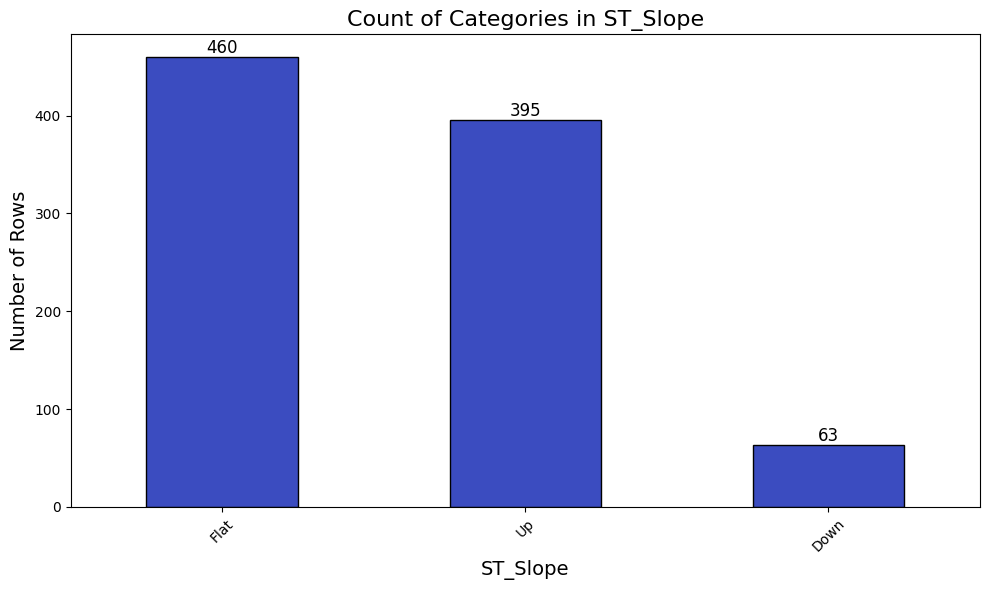

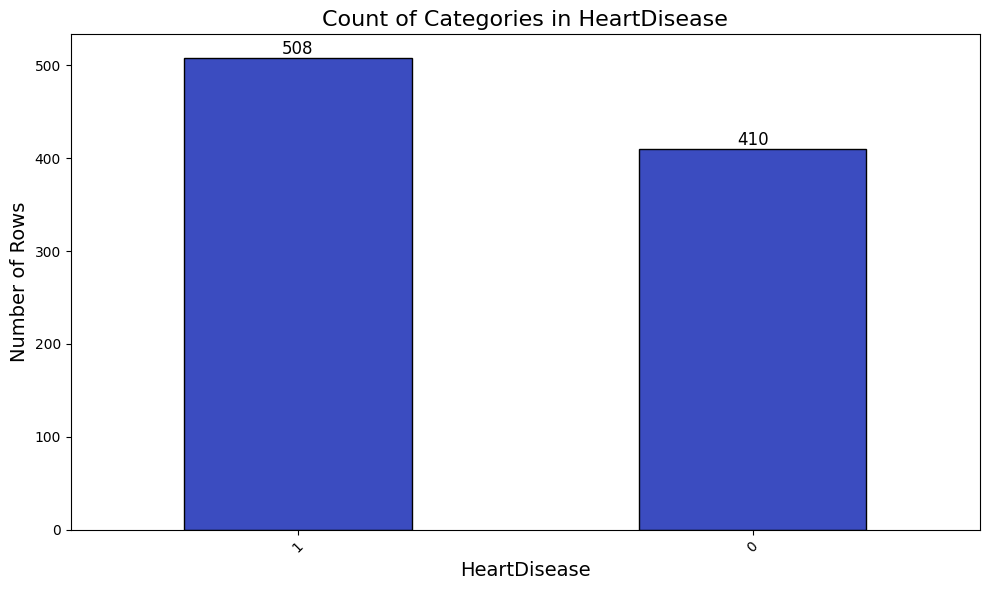

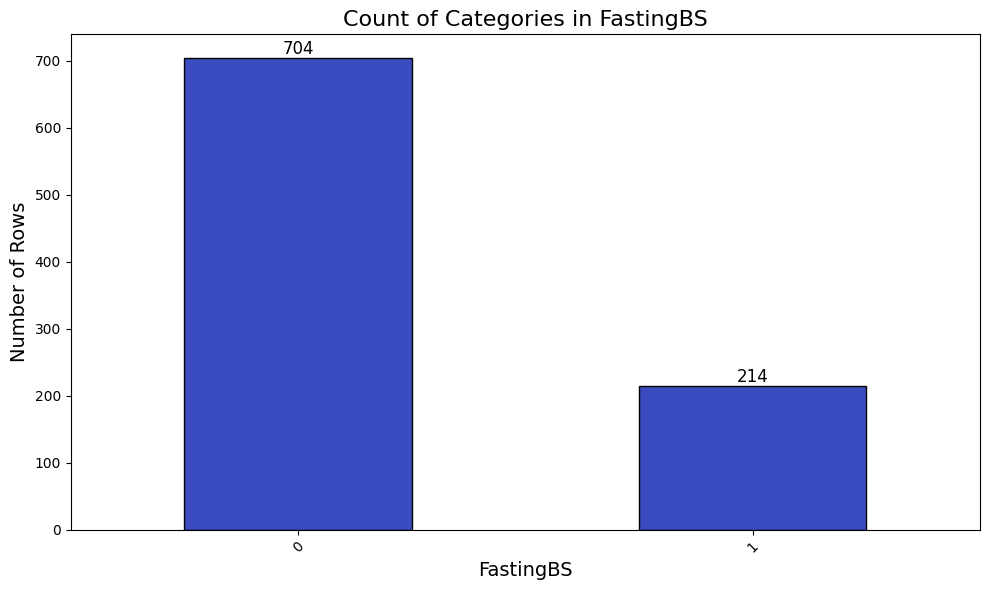

In [13]:
for column in cat_columns:
    plt.figure(figsize=(10, 6))
    df[column].value_counts().plot(kind='bar',colormap='coolwarm',edgecolor='black')
    plt.title(f'Count of Categories in {column}', fontsize=16)
    plt.xlabel(column, fontsize=14)
    plt.ylabel('Number of Rows', fontsize=14)
    
    for index, value in enumerate(df[column].value_counts()):
        plt.text(index, value, str(value), ha='center', va='bottom', fontsize=12)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [14]:
cat_columns

['Sex',
 'ChestPainType',
 'RestingECG',
 'ExerciseAngina',
 'ST_Slope',
 'HeartDisease',
 'FastingBS']

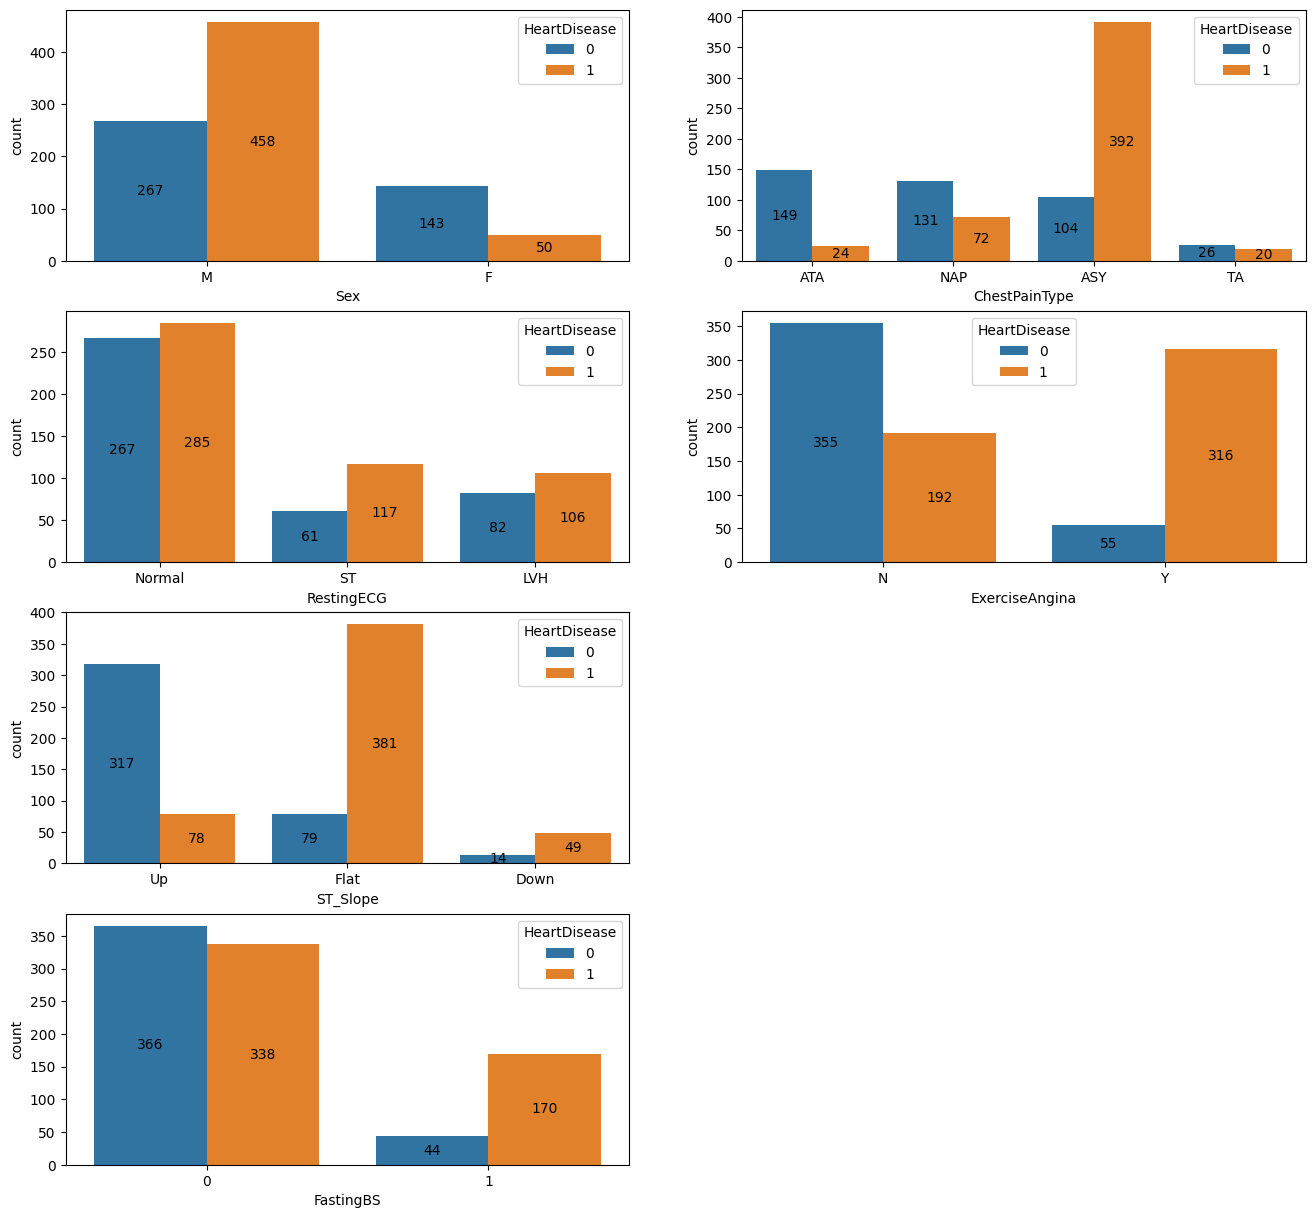

In [15]:

fig = plt.figure(figsize=(16,15))

for idx, col in enumerate(cat_columns):
    if col == 'HeartDisease':
        continue 
    ax = plt.subplot(4, 2, idx+1)
    # group by HeartDisease
    sns.countplot(x=df[col], hue=df["HeartDisease"], ax=ax)
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")


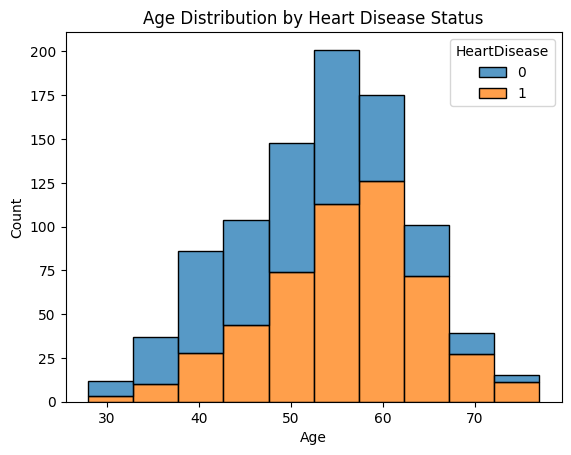

In [16]:
sns.histplot(data=df, x='Age', bins=10, hue='HeartDisease', multiple='stack')
plt.title('Age Distribution by Heart Disease Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

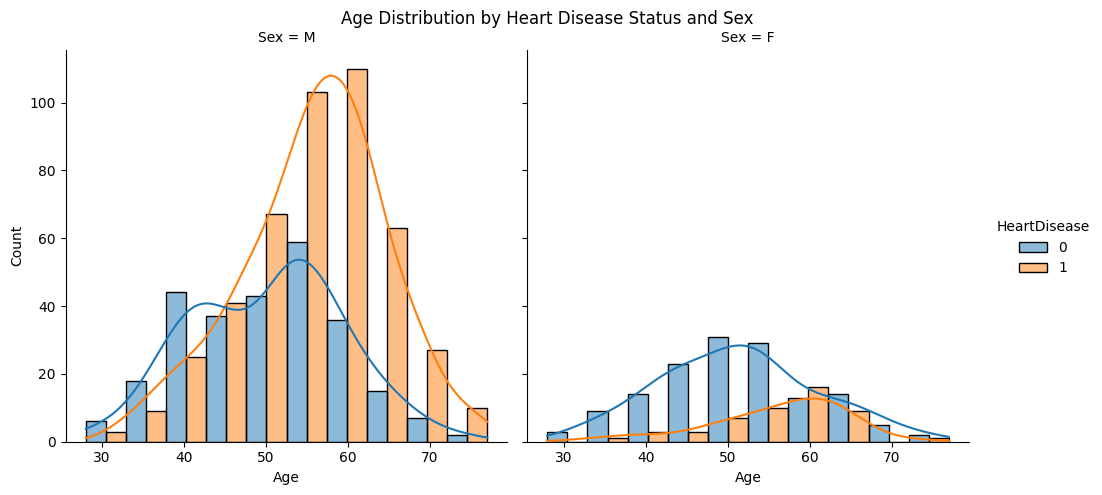

In [17]:
g = sns.displot(data=df, x='Age', bins=10, hue='HeartDisease', col='Sex', 
                 multiple='dodge',kde=True)
plt.subplots_adjust(top=0.9)
g.figure.suptitle('Age Distribution by Heart Disease Status and Sex')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

We also plotted our categorical columns and observed a few details:

- The dataset is highly skewed towards male patients. 725 rows correspond to male patients, whereas only 193 correspond to female patients. This could potentially induce a bias in our model and impact predictions for any female patients in any unseen data.
- 410 patients were not diagnosed with heart disease, whereas 508 patients were. The target variable is somewhat evenly distributed, which is beneficial for training our model.
- A significant number of patients, 392, diagnosed with heart disease have asymptomatic (ASY) chest pain. While chest pain could be a relevant feature for our model, it's should be noted that asymptomatic implies that those patients who had heart disease did not have chest pain as a symptom.
- A high number (170) of patients with blood sugar greater than 120 mg/dl were diagnosed with heart disease in relation to those who were not.

# Data Cleaning

In [18]:
df[df["RestingBP"] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


RestingBP has only one zero value. So, We can remove that row from consideration.

In [19]:
df = df[df['RestingBP'] != 0]

In [20]:
df[df['Cholesterol'] == 0].shape

(171, 12)

In [21]:
median_age = df['Cholesterol'].replace(0, pd.NA).median()
df['Cholesterol'] = df['Cholesterol'].replace(0, median_age)

In [22]:
df[["Cholesterol", "RestingBP"]].describe()

,Cholesterol,RestingBP
count,917.000000,917.000000
mean,243.211559,132.540894
std,53.430044,17.999749
min,85.000000,80.000000
25%,214.000000,120.000000
50%,237.000000,130.000000
75%,267.000000,140.000000
max,603.000000,200.000000


In [23]:
df_dummies = pd.get_dummies(df, drop_first=True)
df_dummies.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_M,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,True,True,False,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,True,True,False,False,False,True,False,False,True
3,48,138,214,0,108,1.5,1,False,False,False,False,True,False,True,True,False
4,54,150,195,0,122,0.0,0,True,False,True,False,True,False,False,False,True


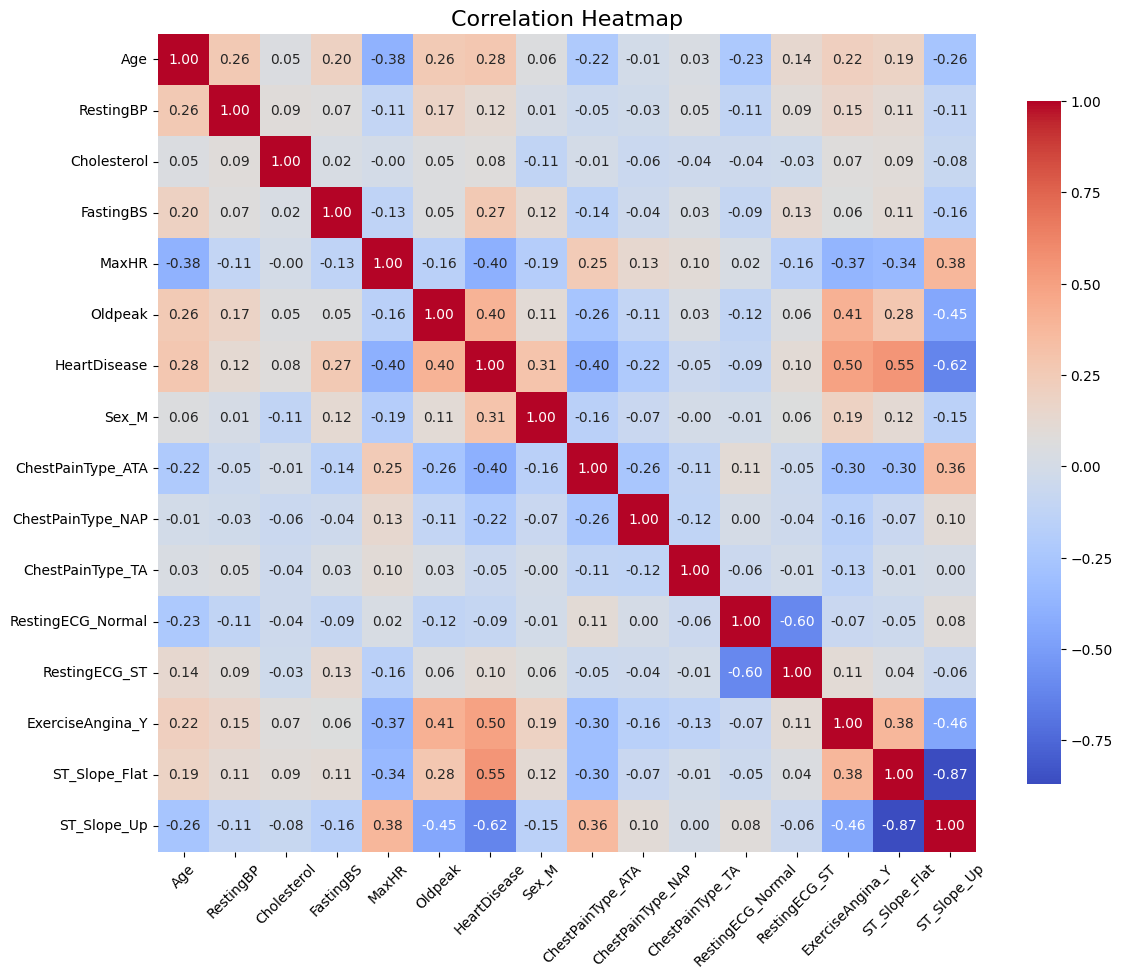

In [24]:
corr_matrix = df_dummies.corr()

plt.figure(figsize=(12, 10))

sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

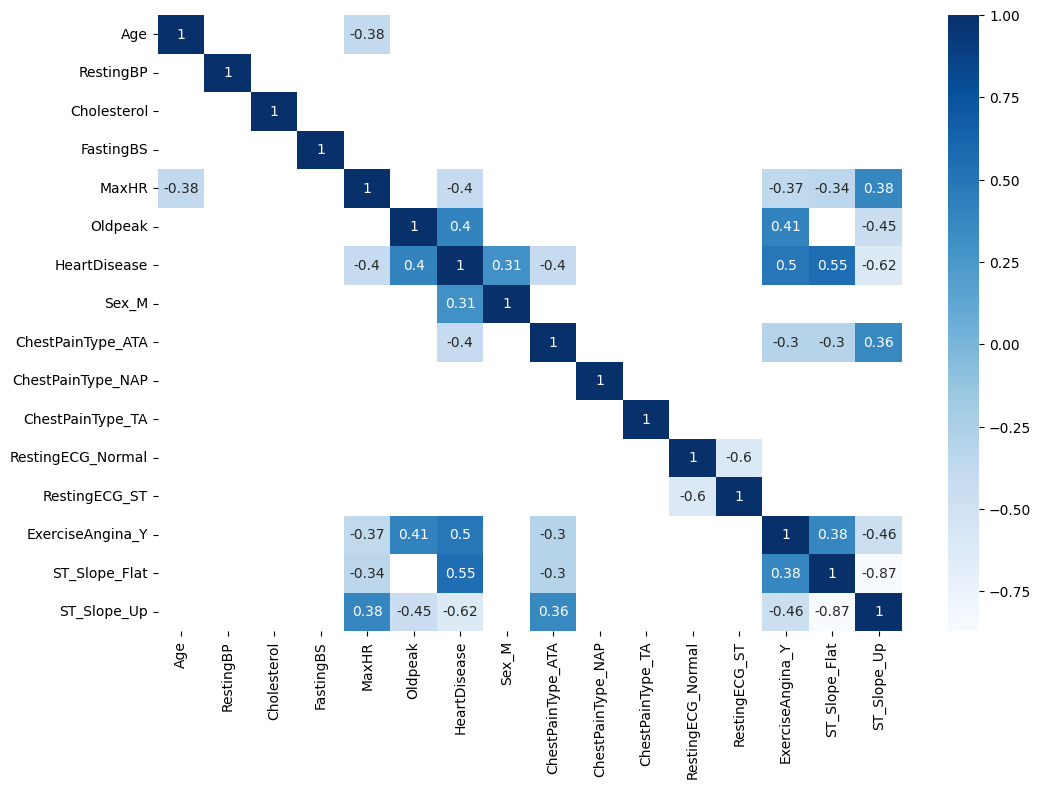

In [25]:
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix[abs(corr_matrix) > 0.3], annot=True, cmap="Blues")
plt.show()

In [26]:
target = 'HeartDisease'
corr_matrix = abs(df_dummies.corr()[target])  # Square the correlation coefficients

# Select features with a threshold (e.g., > 0.1)
threshold = 0.1
selected_features = corr_matrix[corr_matrix > threshold]

print("Selected Features:")
print(selected_features)

Selected Features:
Age                  0.282012
RestingBP            0.117990
FastingBS            0.267994
MaxHR                0.401410
Oldpeak              0.403638
HeartDisease         1.000000
Sex_M                0.305118
ChestPainType_ATA    0.401680
ChestPainType_NAP    0.215311
RestingECG_ST        0.103067
ExerciseAngina_Y     0.495490
ST_Slope_Flat        0.553700
ST_Slope_Up          0.621843
Name: HeartDisease, dtype: float64


In [27]:
target = 'HeartDisease'
corr_matrix_sq = df_dummies.corr()[target]**2  # Square the correlation coefficients

# Select features with a threshold (e.g., > 0.1)
threshold = 0.1
selected_features_sq = corr_matrix_sq[corr_matrix_sq > threshold]

print("Selected Features:")
print(selected_features_sq)

Selected Features:
MaxHR                0.161130
Oldpeak              0.162924
HeartDisease         1.000000
ChestPainType_ATA    0.161346
ExerciseAngina_Y     0.245510
ST_Slope_Flat        0.306584
ST_Slope_Up          0.386688
Name: HeartDisease, dtype: float64


Selected Features:
- MaxHR                0.161130
- Oldpeak              0.162924
- Sex_M                0.0961 (From EDA)
- ChestPainType_ATA    0.161346
- ExerciseAngina_Y     0.245510
- ST_Slope_Flat        0.306584
- ST_Slope_Up          0.386688

In [28]:
X = df_dummies[["MaxHR", "Oldpeak", "Sex_M", "ChestPainType_ATA", "ExerciseAngina_Y", "ST_Slope_Flat", "ST_Slope_Up"]]

In [29]:
Y = df_dummies["HeartDisease"]

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(779, 7) (138, 7) (779,) (138,)


In [31]:
selected_features = ["MaxHR", "Oldpeak", "Sex_M", "ChestPainType_ATA", "ExerciseAngina_Y", "ST_Slope_Flat", "ST_Slope_Up"]

In [32]:
n_neighbors = 3
for feature in selected_features:
    X_train_feature = X_train[[feature]]
    X_test_feature = X_test[[feature]]
    
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train_feature, Y_train)
    
    Y_pred = knn.predict(X_test_feature)
    
    accuracy = accuracy_score(Y_test, Y_pred)
    print(f"Feature: {feature}, Accuracy: {accuracy:.2f}")

Feature: MaxHR, Accuracy: 0.64
Feature: Oldpeak, Accuracy: 0.54
Feature: Sex_M, Accuracy: 0.38
Feature: ChestPainType_ATA, Accuracy: 0.72
Feature: ExerciseAngina_Y, Accuracy: 0.67
Feature: ST_Slope_Flat, Accuracy: 0.75
Feature: ST_Slope_Up, Accuracy: 0.78


In [33]:
knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_train, Y_train)

Y_pred = knn.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.82


In [34]:

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=n_neighbors)
knn.fit(X_train_scaled, Y_train)

Y_pred = knn.predict(X_test_scaled)

accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.82


In [35]:
# Grid Search for Algorithm Tuning

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)


parameters = {
    'n_neighbors': range(1, 21),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}


knn = KNeighborsClassifier()

# grid_search = GridSearchCV(estimator=knn, param_grid=parameters, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search = GridSearchCV(estimator=knn, param_grid=parameters, scoring='accuracy')

grid_search.fit(X_train_scaled, Y_train)

print(grid_search.best_params_)

print(grid_search.best_score_)

best_knn = grid_search.best_estimator_

{'metric': 'euclidean', 'n_neighbors': 18, 'weights': 'uniform'}
0.851025641025641


In [36]:
X_test_scaled = scaler.transform(X_test)
Y_pred = best_knn.predict(X_test_scaled)

accuracy = accuracy_score(Y_test, Y_pred)

print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.82


In [37]:

conf_matrix = confusion_matrix(Y_test, Y_pred)

conf_matrix

array([[45,  8],
       [17, 68]], dtype=int64)

In [38]:


class_report = classification_report(Y_test, Y_pred)

print(class_report)


roc_auc = roc_auc_score(Y_test, Y_pred)

print(f"ROC AUC: {roc_auc:.2f}")

              precision    recall  f1-score   support

           0       0.73      0.85      0.78        53
           1       0.89      0.80      0.84        85

    accuracy                           0.82       138
   macro avg       0.81      0.82      0.81       138
weighted avg       0.83      0.82      0.82       138

ROC AUC: 0.82


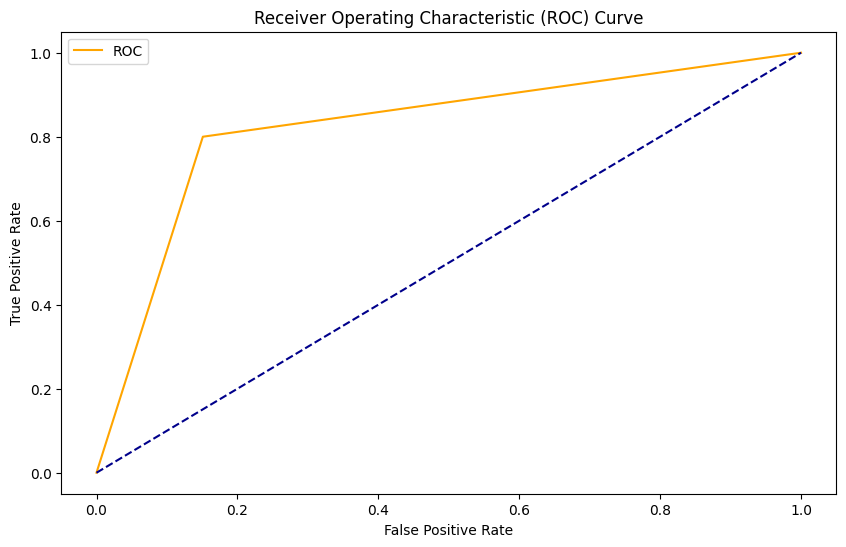

In [39]:


fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)

plt.figure(figsize=(10, 6))

plt.plot(fpr, tpr, color='orange', label='ROC')

plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [40]:
print("Distribution of patients by their sex in the entire dataset")
print(X.Sex_M.value_counts())

print("\nDistribution of patients by their sex in the training dataset")
print(X_train.Sex_M.value_counts())

print("\nDistribution of patients by their sex in the test dataset")
print(X_test.Sex_M.value_counts())

Distribution of patients by their sex in the entire dataset
Sex_M
True     724
False    193
Name: count, dtype: int64

Distribution of patients by their sex in the training dataset
Sex_M
True     609
False    170
Name: count, dtype: int64

Distribution of patients by their sex in the test dataset
Sex_M
True     115
False     23
Name: count, dtype: int64


The datasets show a notable imbalance in the number of male and female patients, with significantly more males represented. This disparity raises concerns about potential bias in our model. If the test set has fewer female patients compared to the training set, it could explain why the model performs better in terms of accuracy—it was trained predominantly on male patients. This discrepancy could stem from various factors, but the uneven representation of genders in the data is certainly a contributing element.